In [1]:
import itertools
import timeit
from collections.abc import Iterable, Iterator
from pathlib import Path

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd

from simplexity.generative_processes.generalized_hidden_markov_model import GeneralizedHiddenMarkovModel
from simplexity.generative_processes.generative_process import GenerativeProcess
from simplexity.generative_processes.hidden_markov_model import HiddenMarkovModel

In [2]:
assert jax.default_backend() == 'gpu'
print(jax.devices())

[CudaDevice(id=0)]


In [3]:
repo_dir = Path().absolute().parent
benchmark_data_dir = repo_dir / 'benchmark_data'
if not benchmark_data_dir.exists():
    benchmark_data_dir.mkdir()
print(benchmark_data_dir)

/workspaces/simplexity/benchmark_data


In [4]:
def generate_observations(
        process: GenerativeProcess,
        initial_state: jax.Array,
        sequence_len: int,
        batch_size: int,
        num_batches: int,
    ) -> Iterator[jax.Array]:
    """Yields batches of observations generated from a generative process."""
    key = jax.random.PRNGKey(0)
    states = jnp.repeat(initial_state[None, :], batch_size, axis=0)
    for _ in range(num_batches):
        key, batch_key = jax.random.split(key)
        batch_keys = jax.random.split(batch_key, batch_size)
        states, batch_observations = process.generate(states, batch_keys, sequence_len)
        yield batch_observations

In [5]:
def test_generate_shape(
        process: GenerativeProcess,
        initial_state: jax.Array,
        sequence_len: int = 3,
        batch_size: int = 2,
        num_batches: int = 4,
    ) -> None:
    """Simple test of the generate function."""
    observations = jnp.stack(list(generate_observations(process, initial_state, sequence_len, batch_size, num_batches)))
    assert observations.shape == (num_batches, batch_size, sequence_len)

In [6]:
def time_generate(
        process: GenerativeProcess,
        initial_state: jax.Array,
        sequence_len: int,
        batch_size: int,
        num_batches: int,
        num_runs: int = 1,
    ) -> float:
    """Time the generate function."""
    def run_generate():
        for _ in generate_observations(process, initial_state, sequence_len, batch_size, num_batches):
            pass
    return timeit.timeit(run_generate, number=num_runs) / (num_batches * num_runs)

In [7]:
def get_benchmark_results(
        process: GenerativeProcess,
        initial_state: jax.Array,
        num_batches: int,
        log2_sequence_lengths: Iterable[int] = range(2, 12),
        log2_batch_sizes: Iterable[int] = range(5)
    ) -> pd.DataFrame:
    """Get benchmark results for different combinations of sequence lengths and batch sizes."""
    data = []
    for log2_sequence_len, log2_batch_size in itertools.product(log2_sequence_lengths, log2_batch_sizes):
        sequence_len = 2 ** log2_sequence_len
        batch_size = 2 ** log2_batch_size
        time = time_generate(process, initial_state, sequence_len, batch_size, num_batches)
        data.append({'sequence_len': sequence_len, 'batch_size': batch_size, 'time_per_batch': time})

    return pd.DataFrame.from_records(data)

In [8]:
def plot_benchmark_results(df: pd.DataFrame, model_name: str, num_batches: int) -> None:
    """Plot benchmark results."""
    _, ax = plt.subplots()
    for batch_size, group in df.groupby('batch_size'):
        ax.semilogx(group['sequence_len'], group['time_per_batch'], label=f'batch_size={batch_size}', marker='o')
    ax.legend()
    ax.set_xlabel('Sequence Length')
    ax.set_ylabel('Time per batch (s)')
    ax.set_title(f'{model_name=}, {num_batches=}')
    plt.show()

In [9]:
def benchmark(
        model: GenerativeProcess,
        initial_state: jax.Array,
        model_name: str,
        num_batches: int = 16,
        results_dir: Path = benchmark_data_dir,
    ) -> None:
    """Run a series of benchmark trials for the generative function, plot and save the results."""
    test_generate_shape(model, initial_state)
    df = get_benchmark_results(model, initial_state, num_batches)
    path = results_dir / f'{model_name}_generate_benchmark.csv'
    df.to_csv(path, index=False)
    plot_benchmark_results(df, model_name, num_batches)

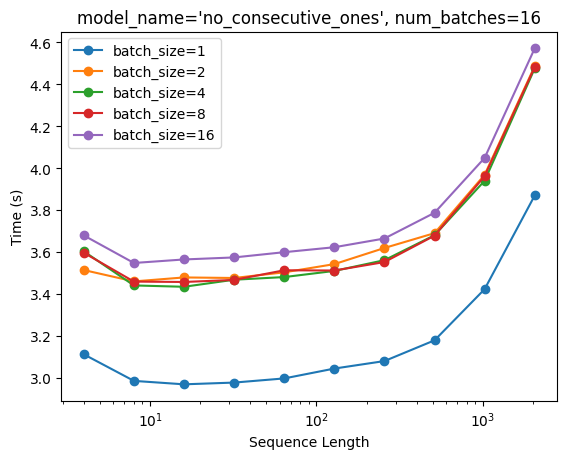

In [10]:
from simplexity.generative_processes.transition_matrices import no_consecutive_ones  # noqa: E402

model_name = 'no_consecutive_ones'
transition_matrices = no_consecutive_ones()
hmm = HiddenMarkovModel(transition_matrices)
initial_state = hmm.state_eigenvector
benchmark(hmm, initial_state, model_name)

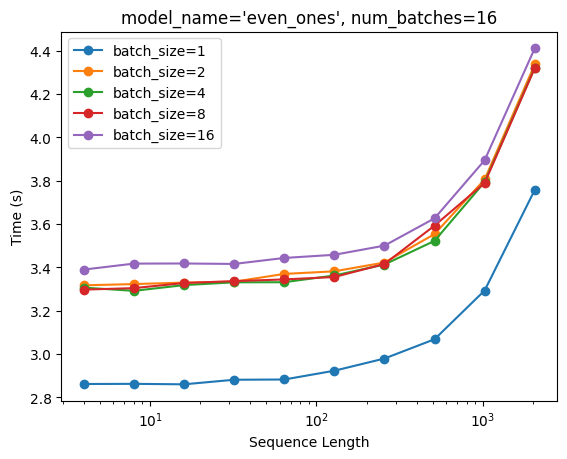

In [11]:
from simplexity.generative_processes.transition_matrices import even_ones  # noqa: E402

model_name = 'even_ones'
transition_matrices = even_ones()
hmm = HiddenMarkovModel(transition_matrices)
initial_state = hmm.state_eigenvector
benchmark(hmm, initial_state, model_name)

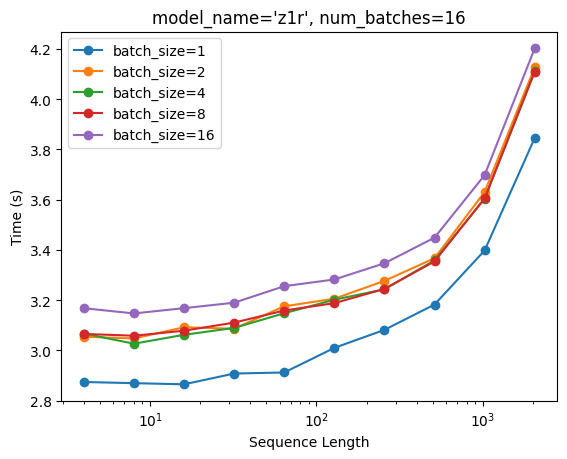

In [12]:
from simplexity.generative_processes.transition_matrices import zero_one_random  # noqa: E402

model_name = 'z1r'
transition_matrices = zero_one_random()
hmm = HiddenMarkovModel(transition_matrices)
initial_state = hmm.state_eigenvector
benchmark(hmm, initial_state, model_name)

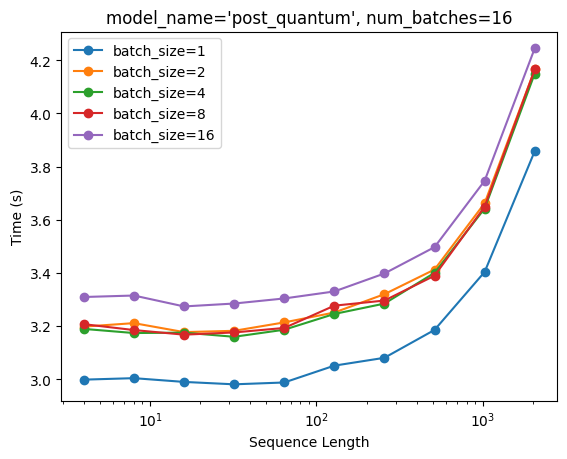

In [13]:
from simplexity.generative_processes.transition_matrices import post_quantum  # noqa: E402

model_name = 'post_quantum'
transition_matrices = post_quantum()
process = GeneralizedHiddenMarkovModel(transition_matrices)
initial_state = process.state_eigenvector
benchmark(process, initial_state, model_name)

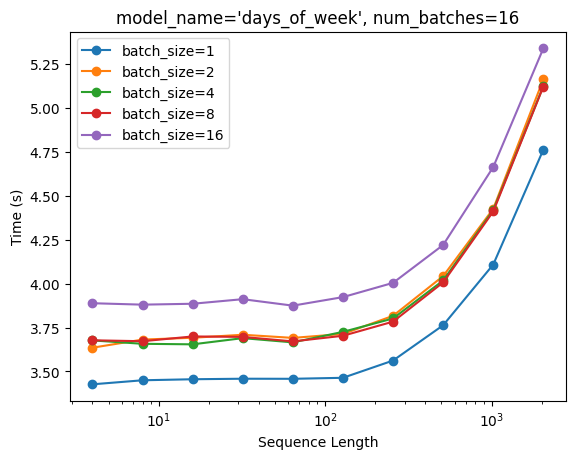

In [14]:
from simplexity.generative_processes.transition_matrices import days_of_week  # noqa: E402

model_name = 'days_of_week'
transition_matrices = days_of_week()
hmm = HiddenMarkovModel(transition_matrices)
initial_state = hmm.state_eigenvector
benchmark(hmm, initial_state, model_name)

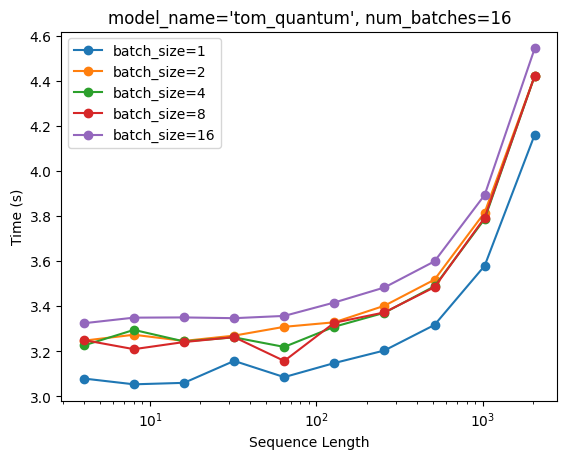

In [15]:
from simplexity.generative_processes.transition_matrices import tom_quantum  # noqa: E402

model_name = 'tom_quantum'
transition_matrices = tom_quantum(alpha=1.0, beta=1.0)
process = GeneralizedHiddenMarkovModel(transition_matrices)
initial_state = process.state_eigenvector
benchmark(process, initial_state, model_name)

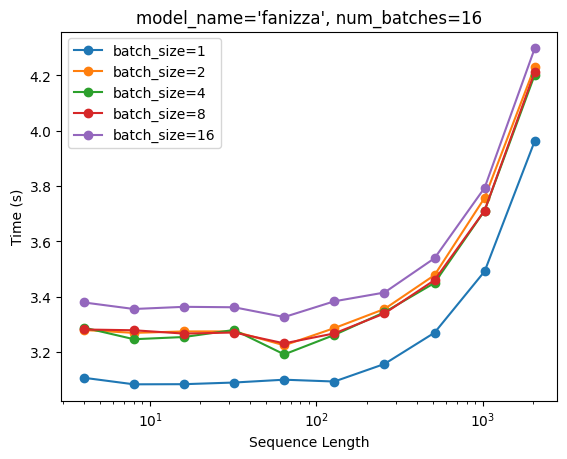

In [16]:
from simplexity.generative_processes.transition_matrices import fanizza  # noqa: E402

model_name = 'fanizza'
transition_matrices = fanizza(alpha=2000, lamb=0.49)
process = GeneralizedHiddenMarkovModel(transition_matrices)
initial_state = process.state_eigenvector
benchmark(process, initial_state, model_name)

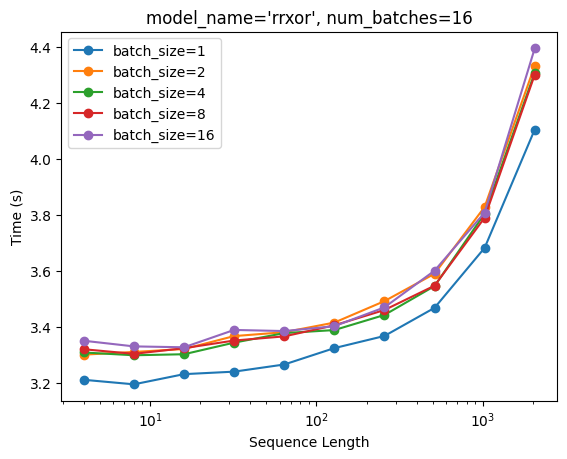

In [17]:
from simplexity.generative_processes.transition_matrices import rrxor  # noqa: E402

model_name = 'rrxor'
transition_matrices = rrxor()
hmm = HiddenMarkovModel(transition_matrices)
initial_state = hmm.state_eigenvector
benchmark(hmm, initial_state, model_name)

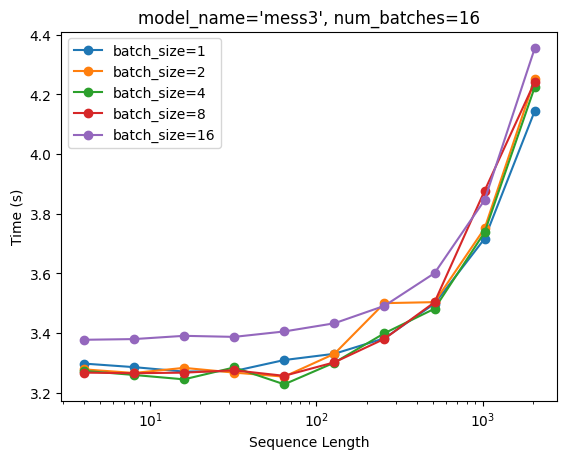

In [18]:
from simplexity.generative_processes.transition_matrices import mess3  # noqa: E402

model_name = 'mess3'
transition_matrices = mess3()
hmm = HiddenMarkovModel(transition_matrices)
initial_state = hmm.state_eigenvector
benchmark(hmm, initial_state, model_name)